# **Rwanda/DRC flooding - working code**

In [ ]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *

## **Local geography**

- DRC: South Kivu province mentioned in trigger, along with Kahele & Nyamukubi
- Rwanda: separate trigger
- no trigger for Burundi/Uganda/Tanzania but may be part of same precipitation event  
&nbsp;
- administrative shapefile data downloaded from https://data.humdata.org/
- elevation data from http://research.jisao.washington.edu/data_sets/elevation/
- river basin shapefiles from https://www.hydrosheds.org/products/hydrobasins



In [84]:
# load gridded elevation data
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(20,40), lat = slice(-15,10))

# load administrative shapefiles
drc = gpd.read_file("sf/drc-adm1").set_index("ADM1_FR")
sk = drc.loc[["Sud-Kivu"]]

ug = gpd.read_file("sf/uganda-adm1").set_index("ADM1_EN")
ugw = ug.loc[["Western"]]

rw = gpd.read_file("sf/rwanda-adm0")
bu = gpd.read_file("sf/burundi-adm0")

# get lat-lon coordinates of named locations; also define location of country labels
px = {k : get_latlon(k).values() for k in ["Kalehe", "Nyamukubi", "Goma", "Bushushu"]}
adm_labels = {"Uganda" : [30.8, 2], "DRC" : [23, -1], "Rwanda" : [31, -2], "Burundi" : [31,-3.4], "Tanzania" : [32.5, -6.5]}

# load shapefile for river basin & clip to required extent
hb05 = gpd.read_file("sf/hybas-lev05").clip([26,-6,33,5])

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


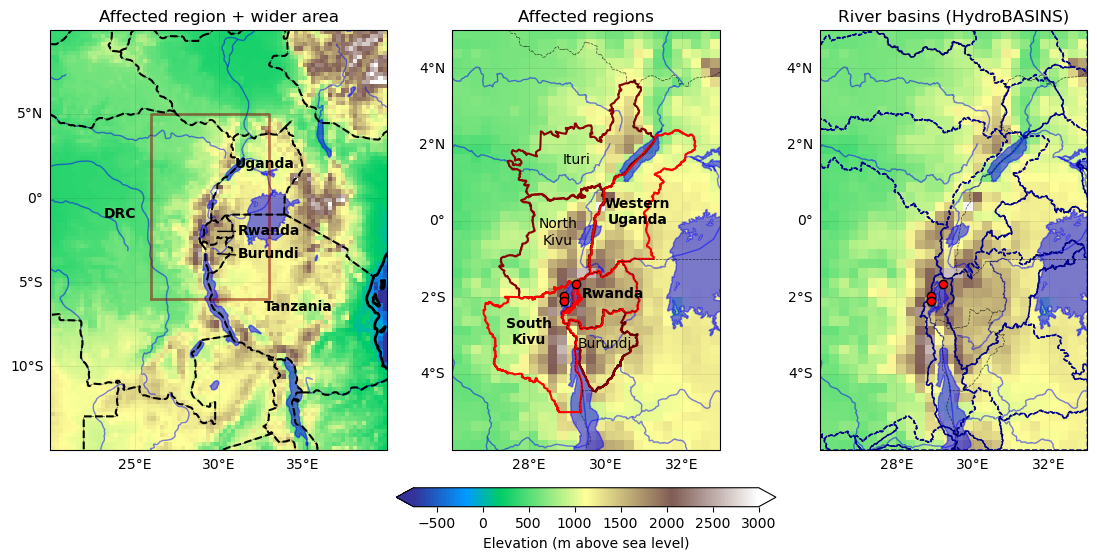

In [96]:
fig, axs = plt.subplots(ncols = 3, figsize = (14,7), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
plt.subplots_adjust(wspace = 0.05)

elev_kwargs = {"cmap" : "terrain", "vmin" : -750, "vmax" : 3000, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[0]
cbar = elev.plot(ax = ax, **elev_kwargs)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left", "bottom"], alpha=0.1, xlocs = np.arange(20,40,5))
ax.set_title("Affected region + wider area")

ax.plot([26,26,33,33,26], [-6,5,5,-6,-6], color = "darkred", lw = 2, alpha = 0.5)
ax.add_feature(cartopy.feature.BORDERS, lw = 1.5, ls = "--", zorder = 99)

[ax.annotate(k, xy = v, fontweight = "bold", textcoords="offset points", xytext=(2,-2), ha='left') for k, v in adm_labels.items()]
ax.plot([rw.geometry.centroid.x[0], adm_labels["Rwanda"][0]], [rw.geometry.centroid.y[0], adm_labels["Rwanda"][1]], color = "k", lw = 1)
ax.plot([bu.geometry.centroid.x[0], adm_labels["Burundi"][0]], [bu.geometry.centroid.y[0], adm_labels["Burundi"][1]], color = "k", lw = 1)

# pd.concat([rw, bu, ugw, drc.loc[["Sud-Kivu", "Nord-Kivu", "Ituri"]]]).explode(index_parts = True).dissolve().boundary.plot(ax = ax)

# rectangle(26,33,-6,5, ax = ax, color = "k", alpha = 0.1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[1]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("Affected regions")

bu.boundary.plot(ax = ax, color = "darkred")
drc.loc[["Nord-Kivu", "Ituri"]].boundary.plot(ax = ax, color = "darkred")

sk.boundary.plot(ax = ax, color = "red")
rw.boundary.plot(ax = ax, color = "red")
ugw.boundary.plot(ax = ax, color = "red")

[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

ax.annotate("South\nKivu", xy = (sk.geometry.centroid.x-0.25, sk.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Rwanda", xy = (rw.geometry.centroid.x+0.25, rw.geometry.centroid.y), ha = "center", fontweight = "bold")
ax.annotate("Western\nUganda", xy = (ugw.geometry.centroid.x+0.1, ugw.geometry.centroid.y-0.5), ha = "center", fontweight = "bold")

ax.annotate("North\nKivu", xy = (drc.loc["Nord-Kivu"].geometry.centroid.x+0.05, drc.loc["Nord-Kivu"].geometry.centroid.y), ha = "center")
ax.annotate("Ituri", xy = (drc.loc["Ituri"].geometry.centroid.x-0.25, drc.loc["Ituri"].geometry.centroid.y-0.25), ha = "center")
ax.annotate("Burundi", xy = (bu.geometry.centroid.x+0.05, bu.geometry.centroid.y), ha = "center")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax = axs[2]
elev.sel(lon = slice(26,33), lat = slice(-6,5)).plot(ax = ax, **elev_kwargs)
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
ax.set_title("River basins (HydroBASINS)")

hb05.boundary.plot(ax = ax, color = "darkblue", lw = 1, ls = "--")
[ax.scatter(*xy, marker = "o", color = "red", edgecolor = "k", zorder = 999) for xy in px.values()]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for ax in axs:

    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS, lw = 0.5, alpha = 0.7, ls = "--", zorder = 99)

    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
    
plt.colorbar(cbar, ax = axs, location = "bottom", extend = "both", shrink = 0.35, pad = 0.07, label = "Elevation (m above sea level)")

plt.savefig("fig/physical-geography.png")

## **Observed precipitation**

_Checked on May 17th: CHIRPS not yet updated_

In [111]:
drc = gpd.read_file("sf/drc-adm1").set_index("ADM1_FR")
sk = drc.loc[["Sud-Kivu"]]

ug = gpd.read_file("sf/uganda-adm1").set_index("ADM1_EN")
ugw = ug.loc[["Western"]]

rw = gpd.read_file("sf/rwanda-adm0")
bu = gpd.read_file("sf/burundi-adm0")

In [176]:
# create combined shapefile to plot area of interest
sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]].exterior

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/tmp/ipykernel_74948/3268929683.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf = pd.concat([drc.loc[["Sud-Kivu", "Nord-Kivu"]], rw, bu, ugw]).clip([26,-6,33,1]).dissolve().explode()
/tmp/ipykernel_74948/3268929683.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() f

### **Maps of the event**

In [259]:
mswep = xr.open_mfdataset("/home/clair/Data/mswep_nrt/2023*.nc").sel(lon = slice(26,33), lat = slice(5,-6), time = "2023-05").precipitation.load()
cpc = xr.open_mfdataset("/home/clair/Data/cpc/precip.2023.nc").sel(lon = slice(26,33), lat = slice(5,-6), time = "2023-05").precip.load()
tamsat = xr.open_dataset("data/01-tamsatDaily.v3.1-1682895600-1688166000_26.0_33.0_-6.0_5.0.nc").rfe_filled.load()

In [ ]:
plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "add_colorbar" : False}

for i in range(3):
    da_name = ["MSWEP", "CPC", "TAMSAT"][i]
    da = eval(da_name.lower())
    vmax = 110
    
    fig, axs = plt.subplots(ncols = 4, figsize = (10,5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})
    plt.subplots_adjust(wspace = 0.05)
    plt.suptitle(da_name, fontsize='x-large', fontweight = "bold")
    
    for j in range(4):
        ax = axs[j]
        cbar = da.sel(time = "2023-05-0"+str(j+1)).plot(ax = ax, vmax = vmax, **plot_kwargs)
        sf.plot(ax = ax, color = "darkred")
        ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.2)
        ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.2)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0.1, xlocs = np.arange(20,40,2), ylocs = range(-6,6,2))
    plt.colorbar(cbar, ax = axs, location = "bottom", shrink = 0.35, pad = 0.1, label = "Precipitation (mm/day)")
    
    plt.savefig("fig/may-precip_"+da_name.lower()+".png"); plt.close()